In [13]:
#Load the libraries
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.config import print_config
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    Resized
)

from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN V

### Setup the file input and output locations

In [14]:
logdir = os.path.normpath("./logs/fine/")

if os.path.exists(logdir) is False:
    os.mkdir(logdir)

In [15]:
#Load the pre-trained model
use_pretrained = True
pretrained_path = os.path.normpath("./logs/best_model_32.pt")

In [16]:
#Convert the train and validation images into a list with locations

train_dir = "./Synth3D"
val_dir = "./Synth3DVal"

#train image file
timage_filenames = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.startswith("im")])
tlabel_filenames = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.startswith("seg")])

#validation image files
vimage_filenames = sorted([os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.startswith("im")])
vlabel_filenames = sorted([os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.startswith("seg")])

# Create a list of dictionaries containing the file paths
train_datalist = [{"image": img, "label": lbl} for img, lbl in zip(vimage_filenames, vlabel_filenames)]
validation_datalist = [{"image": img, "label": lbl} for img, lbl in zip(vimage_filenames, vlabel_filenames)]

# Print the datalist to verify
print(train_datalist, validation_datalist)

[{'image': './Synth3DVal/im0.nii.gz', 'label': './Synth3DVal/seg0.nii.gz'}, {'image': './Synth3DVal/im1.nii.gz', 'label': './Synth3DVal/seg1.nii.gz'}, {'image': './Synth3DVal/im2.nii.gz', 'label': './Synth3DVal/seg2.nii.gz'}, {'image': './Synth3DVal/im3.nii.gz', 'label': './Synth3DVal/seg3.nii.gz'}, {'image': './Synth3DVal/im4.nii.gz', 'label': './Synth3DVal/seg4.nii.gz'}, {'image': './Synth3DVal/im5.nii.gz', 'label': './Synth3DVal/seg5.nii.gz'}, {'image': './Synth3DVal/im6.nii.gz', 'label': './Synth3DVal/seg6.nii.gz'}, {'image': './Synth3DVal/im7.nii.gz', 'label': './Synth3DVal/seg7.nii.gz'}, {'image': './Synth3DVal/im8.nii.gz', 'label': './Synth3DVal/seg8.nii.gz'}, {'image': './Synth3DVal/im9.nii.gz', 'label': './Synth3DVal/seg9.nii.gz'}] [{'image': './Synth3DVal/im0.nii.gz', 'label': './Synth3DVal/seg0.nii.gz'}, {'image': './Synth3DVal/im1.nii.gz', 'label': './Synth3DVal/seg1.nii.gz'}, {'image': './Synth3DVal/im2.nii.gz', 'label': './Synth3DVal/seg2.nii.gz'}, {'image': './Synth3DVal

### Train and validation transforms

In [18]:
# Training Hyper-params
lr = 1e-4
max_iterations = 50
eval_num = 10

# Transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #     keys=["image", "label"],
        #     pixdim=(1.5, 1.5, 4.0),
        #     mode=("bilinear", "nearest"),
        # ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(32, 32, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,),
        # ),
        # RandFlipd(
        #     keys=["image", "label"],
        #     spatial_axis=[0],
        #     prob=0.10,
        # ),
        # RandFlipd(
        #     keys=["image", "label"],
        #     spatial_axis=[1],
        #     prob=0.10,
        # ),
        # RandFlipd(
        #     keys=["image", "label"],
        #     spatial_axis=[2],
        #     prob=0.10,
        # ),
        # RandRotate90d(
        #     keys=["image", "label"],
        #     prob=0.10,
        #     max_k=3,
        # ),
        # RandShiftIntensityd(
        #     keys=["image"],
        #     offsets=0.10,
        #     prob=0.50,
        # ),
        ToTensord(keys=["image", "label"]),
    ]
)

# Validation transforms
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175,
                             a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)


### Dataloaders for train and validation

In [19]:

train_ds = CacheDataset(
    data=train_datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=2,
)
train_loader = DataLoader(train_ds, batch_size=1,
                          shuffle=True, num_workers=4, pin_memory=True)
val_ds = CacheDataset(data=validation_datalist, transform=val_transforms,
                      cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1,
                        shuffle=False, num_workers=4, pin_memory=True)


Loading dataset: 100%|██████████| 6/6 [00:00<00:00, 39.55it/s]


In [118]:
# just conforming the image sizes for the data inside the folder

for case_num in range(len(val_ds)):
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    img_shape = img.shape
    label_shape = label.shape
    print(f"image shape: {img_shape}, label shape: {label_shape}")

image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])
image shape: torch.Size([1, 43, 43, 32]), label shape: torch.Size([1, 43, 43, 32])


### Network

In [20]:
device = torch.device("cpu") # current GPU cannot handle this

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(32, 32, 32),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="conv",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
)

# Load ViT backbone weights into UNETR
if use_pretrained is True:
    print("Loading Weights from the Path {}".format(pretrained_path))
    vit_dict = torch.load(pretrained_path)
    vit_weights = vit_dict["state_dict"]
    model_dict = model.vit.state_dict()

    vit_weights = {k: v for k, v in vit_weights.items() if k in model_dict}
    model_dict.update(vit_weights)
    model.vit.load_state_dict(model_dict)
    del model_dict, vit_weights, vit_dict
    print("Pretrained Weights Succesfully Loaded !")

elif use_pretrained is False:
    print("No weights were loaded, all weights being used are randomly initialized!")

model.to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True,
                         reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []


Loading Weights from the Path logs/best_model_32.pt
Pretrained Weights Succesfully Loaded !


### Train and validation 

In [122]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = []

    with torch.no_grad():
        for _step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (
                batch["image"], batch["label"])
            val_outputs = sliding_window_inference(
                val_inputs, (32, 32, 32), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(
                val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor)
                                  for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice))

        dice_metric.reset()

    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"], batch["label"])
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))

        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)

            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(
                    logdir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )

            plt.figure(1, (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Iteration Average Loss")
            x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("Iteration")
            plt.plot(x, y)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [eval_num * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("Iteration")
            plt.plot(x, y)
            plt.grid()
            plt.savefig(os.path.join(logdir, "btcv_finetune_quick_update.png"))
            plt.clf()
            plt.close(1)

        global_step += 1
    return global_step, dice_val_best, global_step_best


while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(
    os.path.join(logdir, "best_metric_model.pth")))

print(
    f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")


Validate (10 / 10 Steps) (dice=0.07159): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Model Was Saved ! Current Best Avg. Dice: 0.07312348634004592 Current Avg. Dice: 0.07312348634004592


Training (20 / 50 Steps) (loss=3.43219):  10%|█         | 1/10 [00:09<01:22,  9.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.24119106233119963 Current Avg. Dice: 0.24119106233119963


Training (30 / 50 Steps) (loss=3.32284):  10%|█         | 1/10 [00:09<01:22,  9.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.42793580889701843 Current Avg. Dice: 0.42793580889701843


Training (40 / 50 Steps) (loss=3.16704):  10%|█         | 1/10 [00:09<01:26,  9.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5814559459686279 Current Avg. Dice: 0.5814559459686279


Training (49 / 50 Steps) (loss=3.01787): 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


train completed, best_metric: 0.5815 at iteration: 40


In [4]:
import os
import numpy as np
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld, ToTensord
)
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.networks.nets import UNETR
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.metrics import DiceMetric

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN V

In [5]:
# printing the results

# Define the transformation pipeline for the single image
single_image_transforms = Compose(
    [
        LoadImaged(keys=["image"], reader="nrrdreader"),
        EnsureChannelFirstd(keys=["image"]),
        Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-200,
            a_max=200,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        ToTensord(keys=["image"]),
    ]
)


# Example NRRD file path
image_file = "./Synth3DVal/im0.nii.gz"

# Create a dictionary for the single image
single_image_data = [{"image": image_file}]

# Create a Dataset for the single image
single_image_ds = Dataset(data=single_image_data, transform=single_image_transforms)

# Load and preprocess the image
single_image_loader = DataLoader(single_image_ds, batch_size=1)
single_image_batch = next(iter(single_image_loader))
single_image = single_image_batch["image"]

# Print the shape of the preprocessed image
print(f"Preprocessed image shape: {single_image.shape}")


Preprocessed image shape: torch.Size([1, 1, 64, 64, 64])


In [8]:
# Define the model (for example, UNet)
model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(32, 32, 32),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="conv",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).cuda()

# Load pre-trained model weights (modify the path as needed)
model.load_state_dict(torch.load("./logs/fine/best_metric_model.pth"))
model.eval()

# Perform inference
with torch.no_grad():
    single_image = single_image.cuda()
    output = sliding_window_inference(single_image, roi_size=(32, 32, 32), sw_batch_size=1, predictor=model)

# Convert the output to a binary mask
output = torch.argmax(output, dim=1).cpu().numpy()
print(f"Segmentation output shape: {output.shape}")


Segmentation output shape: (1, 64, 64, 64)


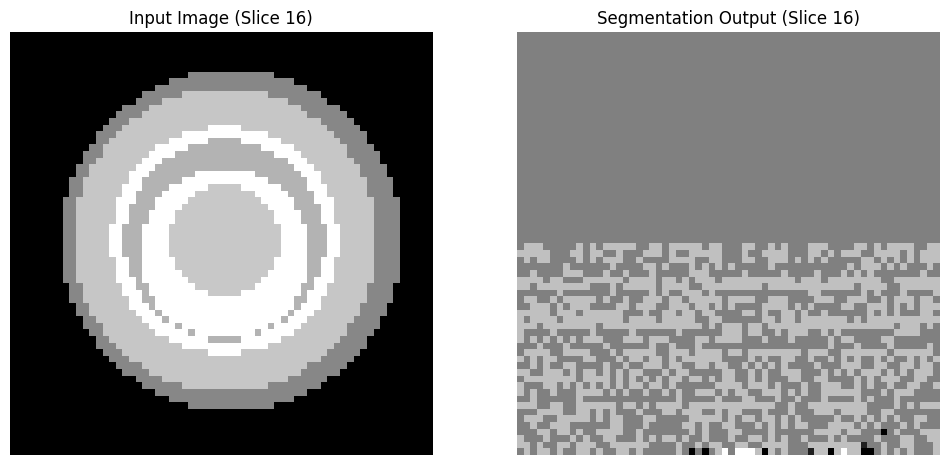

In [12]:
# Extract a slice from the input image and the segmentation output
slice = 20

input_slice = single_image[0, 0, :, :, slice].cpu().numpy()  # Extracting slice 16
output_slice = output[0, :, :, slice]  # Extracting the same slice from the output

# Visualize input and output as subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Input image subplot
axes[0].imshow(input_slice, cmap="gray")
axes[0].set_title("Input Image (Slice 16)")
axes[0].axis("off")

# Segmentation output subplot
axes[1].imshow(output_slice, cmap="gray")
axes[1].set_title("Segmentation Output (Slice 16)")
axes[1].axis("off")

plt.show()
